# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

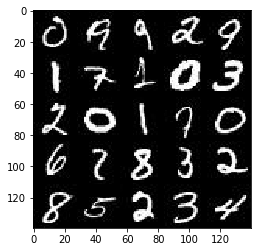

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

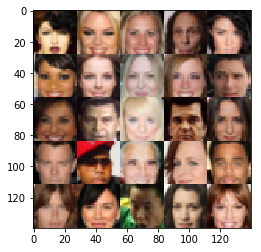

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        keep_prob = 0.5
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob)
        # 14x14x64
        
        x2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, keep_prob=keep_prob)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(drop3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        keep_prob = 0.5
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        # 4x4x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        # 28x28x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out
    
    return None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every=10
    show_every=100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Images are in the range [-0.5,+0.5] and need to be rescaled to [-1,+1].
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                # Run g_opt twice to make sure that d_loss does not go to zero
                # as explained here: http://bamos.github.io/2016/08/09/deep-completion/
                # and here: https://github.com/carpedm20/DCGAN-tensorflow
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9348... Generator Loss: 1.6461
Epoch 1/2... Discriminator Loss: 1.0036... Generator Loss: 1.9226
Epoch 1/2... Discriminator Loss: 1.4050... Generator Loss: 1.8162
Epoch 1/2... Discriminator Loss: 1.2443... Generator Loss: 1.4543
Epoch 1/2... Discriminator Loss: 1.2633... Generator Loss: 1.6731
Epoch 1/2... Discriminator Loss: 1.1941... Generator Loss: 1.3615
Epoch 1/2... Discriminator Loss: 1.2077... Generator Loss: 1.7796
Epoch 1/2... Discriminator Loss: 1.3274... Generator Loss: 1.0206
Epoch 1/2... Discriminator Loss: 1.2507... Generator Loss: 2.2012
Epoch 1/2... Discriminator Loss: 1.5076... Generator Loss: 1.2368


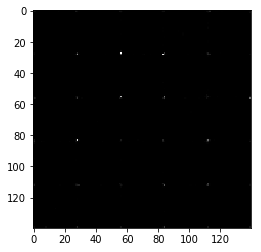

Epoch 1/2... Discriminator Loss: 1.2931... Generator Loss: 1.3035
Epoch 1/2... Discriminator Loss: 1.4256... Generator Loss: 1.7008
Epoch 1/2... Discriminator Loss: 1.2904... Generator Loss: 1.7809
Epoch 1/2... Discriminator Loss: 1.2988... Generator Loss: 2.7117
Epoch 1/2... Discriminator Loss: 1.3218... Generator Loss: 1.0090
Epoch 1/2... Discriminator Loss: 1.2903... Generator Loss: 1.8384
Epoch 1/2... Discriminator Loss: 1.2653... Generator Loss: 1.2723
Epoch 1/2... Discriminator Loss: 1.4650... Generator Loss: 1.2786
Epoch 1/2... Discriminator Loss: 1.2198... Generator Loss: 1.5061
Epoch 1/2... Discriminator Loss: 1.2517... Generator Loss: 1.7337


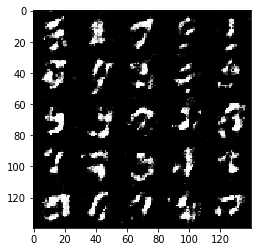

Epoch 1/2... Discriminator Loss: 1.3906... Generator Loss: 1.7175
Epoch 1/2... Discriminator Loss: 0.9770... Generator Loss: 1.3353
Epoch 1/2... Discriminator Loss: 1.1020... Generator Loss: 0.9100
Epoch 1/2... Discriminator Loss: 1.5594... Generator Loss: 1.1930
Epoch 1/2... Discriminator Loss: 1.1882... Generator Loss: 1.5519
Epoch 1/2... Discriminator Loss: 1.3580... Generator Loss: 1.2438
Epoch 1/2... Discriminator Loss: 1.2155... Generator Loss: 1.2598
Epoch 1/2... Discriminator Loss: 1.4732... Generator Loss: 0.7749
Epoch 1/2... Discriminator Loss: 1.2210... Generator Loss: 0.9171
Epoch 1/2... Discriminator Loss: 1.7258... Generator Loss: 0.7136


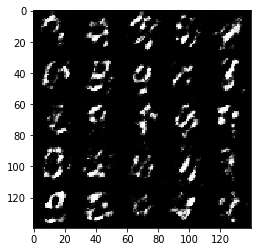

Epoch 1/2... Discriminator Loss: 1.2666... Generator Loss: 0.9329
Epoch 1/2... Discriminator Loss: 1.3542... Generator Loss: 0.7878
Epoch 1/2... Discriminator Loss: 1.2025... Generator Loss: 0.9838
Epoch 1/2... Discriminator Loss: 1.1724... Generator Loss: 1.1228
Epoch 1/2... Discriminator Loss: 1.2253... Generator Loss: 1.3403
Epoch 1/2... Discriminator Loss: 1.4568... Generator Loss: 1.0163
Epoch 1/2... Discriminator Loss: 1.3337... Generator Loss: 0.8079
Epoch 1/2... Discriminator Loss: 1.3830... Generator Loss: 0.8058
Epoch 1/2... Discriminator Loss: 1.2683... Generator Loss: 1.1267
Epoch 1/2... Discriminator Loss: 1.3417... Generator Loss: 1.1070


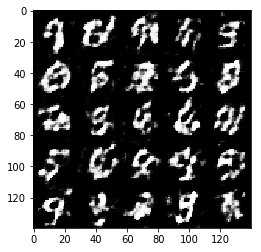

Epoch 1/2... Discriminator Loss: 1.3942... Generator Loss: 1.4533
Epoch 1/2... Discriminator Loss: 1.1766... Generator Loss: 1.4162
Epoch 1/2... Discriminator Loss: 1.1370... Generator Loss: 1.1157
Epoch 1/2... Discriminator Loss: 1.1905... Generator Loss: 1.1928
Epoch 1/2... Discriminator Loss: 0.9900... Generator Loss: 1.2808
Epoch 1/2... Discriminator Loss: 1.3426... Generator Loss: 1.0061
Epoch 1/2... Discriminator Loss: 1.0637... Generator Loss: 0.7921
Epoch 1/2... Discriminator Loss: 1.1852... Generator Loss: 0.9796
Epoch 1/2... Discriminator Loss: 1.1769... Generator Loss: 1.4386
Epoch 1/2... Discriminator Loss: 1.1118... Generator Loss: 1.1804


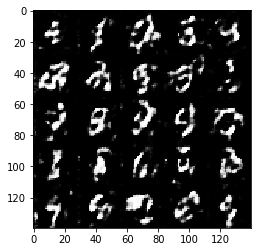

Epoch 1/2... Discriminator Loss: 1.3647... Generator Loss: 0.9926
Epoch 1/2... Discriminator Loss: 0.9366... Generator Loss: 1.2892
Epoch 1/2... Discriminator Loss: 1.2563... Generator Loss: 0.8143
Epoch 1/2... Discriminator Loss: 1.0409... Generator Loss: 1.3410
Epoch 1/2... Discriminator Loss: 1.0907... Generator Loss: 1.4394
Epoch 1/2... Discriminator Loss: 1.0789... Generator Loss: 0.9463
Epoch 1/2... Discriminator Loss: 0.9334... Generator Loss: 1.4161
Epoch 1/2... Discriminator Loss: 1.1114... Generator Loss: 1.5988
Epoch 1/2... Discriminator Loss: 1.0759... Generator Loss: 1.4481
Epoch 1/2... Discriminator Loss: 1.0728... Generator Loss: 1.4252


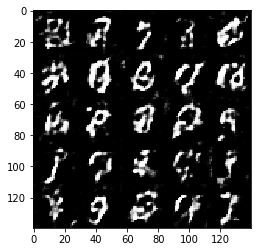

Epoch 1/2... Discriminator Loss: 1.2012... Generator Loss: 1.2371
Epoch 1/2... Discriminator Loss: 1.1793... Generator Loss: 1.0345
Epoch 1/2... Discriminator Loss: 1.2968... Generator Loss: 0.9016
Epoch 1/2... Discriminator Loss: 1.1480... Generator Loss: 1.1893
Epoch 1/2... Discriminator Loss: 1.1089... Generator Loss: 1.7828
Epoch 1/2... Discriminator Loss: 0.9741... Generator Loss: 1.3043
Epoch 1/2... Discriminator Loss: 1.1308... Generator Loss: 1.2239
Epoch 1/2... Discriminator Loss: 1.0446... Generator Loss: 1.1311
Epoch 1/2... Discriminator Loss: 0.9970... Generator Loss: 1.2346
Epoch 1/2... Discriminator Loss: 1.1769... Generator Loss: 1.4716


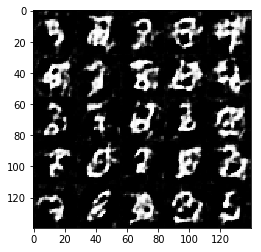

Epoch 1/2... Discriminator Loss: 1.2018... Generator Loss: 0.7141
Epoch 1/2... Discriminator Loss: 1.1224... Generator Loss: 1.2999
Epoch 1/2... Discriminator Loss: 1.1891... Generator Loss: 1.5156
Epoch 1/2... Discriminator Loss: 1.2035... Generator Loss: 1.0188
Epoch 1/2... Discriminator Loss: 1.3405... Generator Loss: 1.6838
Epoch 1/2... Discriminator Loss: 0.9383... Generator Loss: 1.6105
Epoch 1/2... Discriminator Loss: 1.1121... Generator Loss: 1.7821
Epoch 1/2... Discriminator Loss: 1.1077... Generator Loss: 1.0774
Epoch 1/2... Discriminator Loss: 1.1891... Generator Loss: 1.8069
Epoch 1/2... Discriminator Loss: 1.0593... Generator Loss: 1.2117


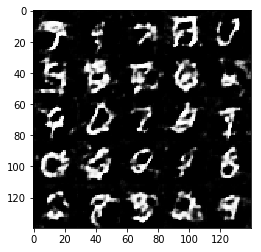

Epoch 1/2... Discriminator Loss: 1.2324... Generator Loss: 1.0377
Epoch 1/2... Discriminator Loss: 1.2874... Generator Loss: 1.0909
Epoch 1/2... Discriminator Loss: 1.0979... Generator Loss: 1.5562
Epoch 1/2... Discriminator Loss: 1.1093... Generator Loss: 1.6485
Epoch 1/2... Discriminator Loss: 1.1733... Generator Loss: 1.8903
Epoch 1/2... Discriminator Loss: 1.0939... Generator Loss: 1.8291
Epoch 1/2... Discriminator Loss: 1.1670... Generator Loss: 1.5668
Epoch 1/2... Discriminator Loss: 1.2960... Generator Loss: 0.7103
Epoch 1/2... Discriminator Loss: 1.1430... Generator Loss: 1.0324
Epoch 1/2... Discriminator Loss: 1.1444... Generator Loss: 1.0777


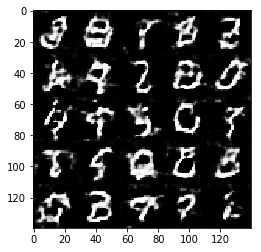

Epoch 1/2... Discriminator Loss: 1.1971... Generator Loss: 0.9379
Epoch 1/2... Discriminator Loss: 1.2655... Generator Loss: 1.2483
Epoch 1/2... Discriminator Loss: 1.2738... Generator Loss: 1.2653
Epoch 1/2... Discriminator Loss: 1.0702... Generator Loss: 0.9014
Epoch 1/2... Discriminator Loss: 0.9335... Generator Loss: 1.2882
Epoch 1/2... Discriminator Loss: 1.2809... Generator Loss: 1.2735
Epoch 1/2... Discriminator Loss: 1.1543... Generator Loss: 0.9953
Epoch 1/2... Discriminator Loss: 1.1175... Generator Loss: 1.1896
Epoch 1/2... Discriminator Loss: 1.1750... Generator Loss: 1.0118
Epoch 1/2... Discriminator Loss: 1.1869... Generator Loss: 1.9621


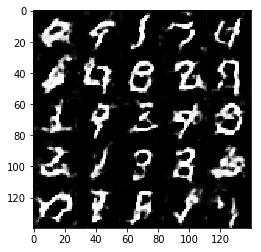

Epoch 1/2... Discriminator Loss: 1.4871... Generator Loss: 0.8508
Epoch 1/2... Discriminator Loss: 1.3270... Generator Loss: 0.9266
Epoch 1/2... Discriminator Loss: 1.1766... Generator Loss: 1.5049
Epoch 1/2... Discriminator Loss: 1.1335... Generator Loss: 1.2881
Epoch 1/2... Discriminator Loss: 1.1925... Generator Loss: 1.3857
Epoch 1/2... Discriminator Loss: 1.2841... Generator Loss: 1.1391
Epoch 1/2... Discriminator Loss: 1.2490... Generator Loss: 0.9855
Epoch 1/2... Discriminator Loss: 1.2246... Generator Loss: 1.0691
Epoch 1/2... Discriminator Loss: 1.1652... Generator Loss: 1.3824
Epoch 1/2... Discriminator Loss: 1.1173... Generator Loss: 0.9531


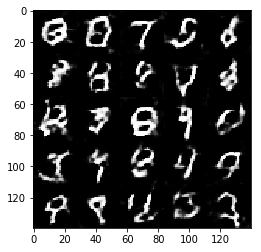

Epoch 1/2... Discriminator Loss: 0.9783... Generator Loss: 1.1493
Epoch 1/2... Discriminator Loss: 1.1188... Generator Loss: 1.3513
Epoch 1/2... Discriminator Loss: 1.1784... Generator Loss: 1.1906
Epoch 1/2... Discriminator Loss: 1.2972... Generator Loss: 1.0104
Epoch 1/2... Discriminator Loss: 1.3127... Generator Loss: 1.1100
Epoch 1/2... Discriminator Loss: 1.1904... Generator Loss: 1.0282
Epoch 1/2... Discriminator Loss: 1.0904... Generator Loss: 0.8769
Epoch 1/2... Discriminator Loss: 1.2941... Generator Loss: 1.1994
Epoch 1/2... Discriminator Loss: 1.2498... Generator Loss: 1.1120
Epoch 1/2... Discriminator Loss: 1.0979... Generator Loss: 1.0107


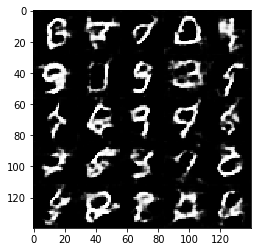

Epoch 1/2... Discriminator Loss: 1.1495... Generator Loss: 1.2333
Epoch 1/2... Discriminator Loss: 1.1303... Generator Loss: 1.0701
Epoch 1/2... Discriminator Loss: 1.0704... Generator Loss: 1.0735
Epoch 1/2... Discriminator Loss: 1.0778... Generator Loss: 1.1493
Epoch 1/2... Discriminator Loss: 1.2705... Generator Loss: 1.3148
Epoch 1/2... Discriminator Loss: 1.1568... Generator Loss: 1.0421
Epoch 1/2... Discriminator Loss: 1.1368... Generator Loss: 1.0534
Epoch 1/2... Discriminator Loss: 1.3344... Generator Loss: 1.6206
Epoch 1/2... Discriminator Loss: 1.1677... Generator Loss: 1.3435
Epoch 1/2... Discriminator Loss: 1.1231... Generator Loss: 1.3520


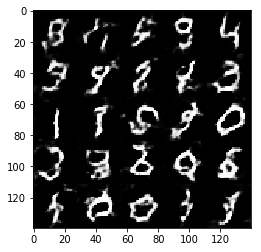

Epoch 1/2... Discriminator Loss: 1.1473... Generator Loss: 0.7784
Epoch 1/2... Discriminator Loss: 1.0763... Generator Loss: 1.3573
Epoch 1/2... Discriminator Loss: 1.0060... Generator Loss: 1.4425
Epoch 1/2... Discriminator Loss: 1.1463... Generator Loss: 1.0045
Epoch 1/2... Discriminator Loss: 1.1042... Generator Loss: 1.0907
Epoch 1/2... Discriminator Loss: 1.2418... Generator Loss: 1.5483
Epoch 1/2... Discriminator Loss: 1.1956... Generator Loss: 1.3368
Epoch 1/2... Discriminator Loss: 1.2691... Generator Loss: 1.1452
Epoch 1/2... Discriminator Loss: 0.9723... Generator Loss: 1.0317
Epoch 1/2... Discriminator Loss: 1.1307... Generator Loss: 1.2825


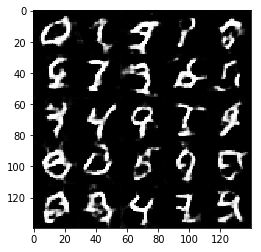

Epoch 1/2... Discriminator Loss: 1.1803... Generator Loss: 1.3241
Epoch 1/2... Discriminator Loss: 1.2200... Generator Loss: 1.3895
Epoch 1/2... Discriminator Loss: 1.1933... Generator Loss: 1.2780
Epoch 1/2... Discriminator Loss: 1.2022... Generator Loss: 1.0854
Epoch 1/2... Discriminator Loss: 1.1499... Generator Loss: 0.9937
Epoch 1/2... Discriminator Loss: 1.0464... Generator Loss: 1.6134
Epoch 1/2... Discriminator Loss: 1.2616... Generator Loss: 0.8544
Epoch 1/2... Discriminator Loss: 1.1949... Generator Loss: 1.1569
Epoch 1/2... Discriminator Loss: 0.9943... Generator Loss: 1.1146
Epoch 1/2... Discriminator Loss: 1.3018... Generator Loss: 0.9544


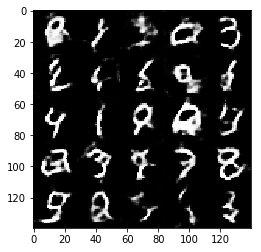

Epoch 1/2... Discriminator Loss: 1.4255... Generator Loss: 1.0341
Epoch 1/2... Discriminator Loss: 1.1150... Generator Loss: 1.0571
Epoch 1/2... Discriminator Loss: 1.2055... Generator Loss: 1.2648
Epoch 1/2... Discriminator Loss: 1.3017... Generator Loss: 1.8065
Epoch 1/2... Discriminator Loss: 1.2279... Generator Loss: 1.1173
Epoch 1/2... Discriminator Loss: 1.1312... Generator Loss: 1.0642
Epoch 1/2... Discriminator Loss: 1.3195... Generator Loss: 0.9342
Epoch 1/2... Discriminator Loss: 1.0128... Generator Loss: 1.5349
Epoch 1/2... Discriminator Loss: 1.1499... Generator Loss: 1.0344
Epoch 1/2... Discriminator Loss: 1.4238... Generator Loss: 1.1496


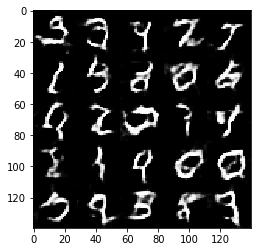

Epoch 1/2... Discriminator Loss: 1.2443... Generator Loss: 1.0797
Epoch 1/2... Discriminator Loss: 1.1552... Generator Loss: 1.3237
Epoch 1/2... Discriminator Loss: 1.1418... Generator Loss: 1.0412
Epoch 1/2... Discriminator Loss: 1.1166... Generator Loss: 1.1999
Epoch 1/2... Discriminator Loss: 1.2265... Generator Loss: 0.9600
Epoch 1/2... Discriminator Loss: 1.1653... Generator Loss: 0.9172
Epoch 1/2... Discriminator Loss: 1.1772... Generator Loss: 1.2334
Epoch 1/2... Discriminator Loss: 1.2124... Generator Loss: 1.0365
Epoch 1/2... Discriminator Loss: 1.2990... Generator Loss: 1.0054
Epoch 1/2... Discriminator Loss: 1.2745... Generator Loss: 0.8899


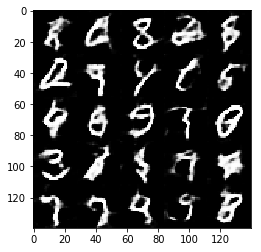

Epoch 1/2... Discriminator Loss: 0.9278... Generator Loss: 1.2767
Epoch 1/2... Discriminator Loss: 1.3125... Generator Loss: 1.2899
Epoch 1/2... Discriminator Loss: 1.0007... Generator Loss: 1.2297
Epoch 1/2... Discriminator Loss: 1.4031... Generator Loss: 1.3595
Epoch 1/2... Discriminator Loss: 1.0448... Generator Loss: 1.0140
Epoch 1/2... Discriminator Loss: 1.0071... Generator Loss: 1.6231
Epoch 1/2... Discriminator Loss: 1.1866... Generator Loss: 1.4554
Epoch 1/2... Discriminator Loss: 1.1510... Generator Loss: 1.3135
Epoch 1/2... Discriminator Loss: 1.1101... Generator Loss: 1.5412
Epoch 1/2... Discriminator Loss: 1.2447... Generator Loss: 1.1300


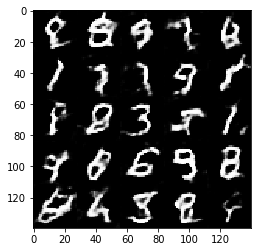

Epoch 1/2... Discriminator Loss: 1.2611... Generator Loss: 0.9759
Epoch 1/2... Discriminator Loss: 1.4811... Generator Loss: 1.4895
Epoch 1/2... Discriminator Loss: 1.1713... Generator Loss: 1.0135
Epoch 1/2... Discriminator Loss: 0.9751... Generator Loss: 1.1972
Epoch 1/2... Discriminator Loss: 1.1078... Generator Loss: 1.3841
Epoch 1/2... Discriminator Loss: 1.2423... Generator Loss: 1.5527
Epoch 1/2... Discriminator Loss: 1.1333... Generator Loss: 0.9443
Epoch 2/2... Discriminator Loss: 1.1978... Generator Loss: 1.0872
Epoch 2/2... Discriminator Loss: 1.0810... Generator Loss: 0.9677
Epoch 2/2... Discriminator Loss: 1.1289... Generator Loss: 1.1728


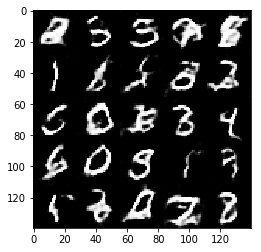

Epoch 2/2... Discriminator Loss: 1.1387... Generator Loss: 1.3810
Epoch 2/2... Discriminator Loss: 1.1656... Generator Loss: 0.8081
Epoch 2/2... Discriminator Loss: 1.2124... Generator Loss: 1.6040
Epoch 2/2... Discriminator Loss: 1.0068... Generator Loss: 1.2891
Epoch 2/2... Discriminator Loss: 1.1941... Generator Loss: 0.8734
Epoch 2/2... Discriminator Loss: 1.2361... Generator Loss: 0.9785
Epoch 2/2... Discriminator Loss: 0.9486... Generator Loss: 1.4585
Epoch 2/2... Discriminator Loss: 0.9933... Generator Loss: 1.2879
Epoch 2/2... Discriminator Loss: 1.1179... Generator Loss: 1.4932
Epoch 2/2... Discriminator Loss: 0.8906... Generator Loss: 1.4075


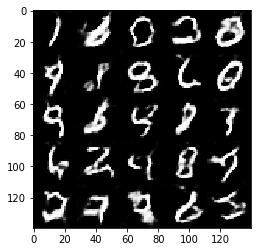

Epoch 2/2... Discriminator Loss: 1.3593... Generator Loss: 0.8507
Epoch 2/2... Discriminator Loss: 1.2073... Generator Loss: 1.0366
Epoch 2/2... Discriminator Loss: 1.0801... Generator Loss: 1.4081
Epoch 2/2... Discriminator Loss: 1.1160... Generator Loss: 1.1307
Epoch 2/2... Discriminator Loss: 1.1969... Generator Loss: 1.2739
Epoch 2/2... Discriminator Loss: 1.0159... Generator Loss: 1.7156
Epoch 2/2... Discriminator Loss: 1.1755... Generator Loss: 0.9696
Epoch 2/2... Discriminator Loss: 0.9574... Generator Loss: 1.1429
Epoch 2/2... Discriminator Loss: 1.2119... Generator Loss: 1.6736
Epoch 2/2... Discriminator Loss: 1.1326... Generator Loss: 0.9147


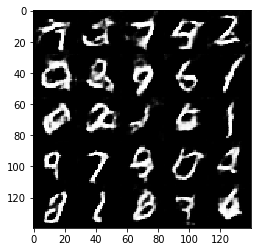

Epoch 2/2... Discriminator Loss: 1.0454... Generator Loss: 1.4345
Epoch 2/2... Discriminator Loss: 1.0364... Generator Loss: 1.0174
Epoch 2/2... Discriminator Loss: 1.1671... Generator Loss: 1.3785
Epoch 2/2... Discriminator Loss: 1.0753... Generator Loss: 1.1147
Epoch 2/2... Discriminator Loss: 1.1313... Generator Loss: 1.1115
Epoch 2/2... Discriminator Loss: 1.1092... Generator Loss: 1.2388
Epoch 2/2... Discriminator Loss: 1.2835... Generator Loss: 1.2866
Epoch 2/2... Discriminator Loss: 1.0350... Generator Loss: 1.8866
Epoch 2/2... Discriminator Loss: 1.1854... Generator Loss: 1.3766
Epoch 2/2... Discriminator Loss: 1.4014... Generator Loss: 0.9288


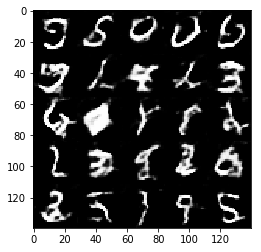

Epoch 2/2... Discriminator Loss: 1.1544... Generator Loss: 1.1852
Epoch 2/2... Discriminator Loss: 1.2729... Generator Loss: 1.0983
Epoch 2/2... Discriminator Loss: 1.1874... Generator Loss: 0.8888
Epoch 2/2... Discriminator Loss: 1.3474... Generator Loss: 1.3848
Epoch 2/2... Discriminator Loss: 0.9601... Generator Loss: 1.3571
Epoch 2/2... Discriminator Loss: 1.2115... Generator Loss: 1.2852
Epoch 2/2... Discriminator Loss: 1.0089... Generator Loss: 1.5192
Epoch 2/2... Discriminator Loss: 1.2033... Generator Loss: 0.8820
Epoch 2/2... Discriminator Loss: 1.2038... Generator Loss: 1.1869
Epoch 2/2... Discriminator Loss: 1.2045... Generator Loss: 1.3692


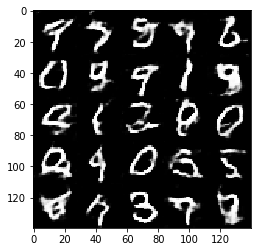

Epoch 2/2... Discriminator Loss: 1.1878... Generator Loss: 1.3129
Epoch 2/2... Discriminator Loss: 1.4765... Generator Loss: 1.3002
Epoch 2/2... Discriminator Loss: 1.1050... Generator Loss: 1.2493
Epoch 2/2... Discriminator Loss: 1.0985... Generator Loss: 1.5243
Epoch 2/2... Discriminator Loss: 0.9937... Generator Loss: 1.2313
Epoch 2/2... Discriminator Loss: 1.1649... Generator Loss: 1.3883
Epoch 2/2... Discriminator Loss: 1.2446... Generator Loss: 1.1975
Epoch 2/2... Discriminator Loss: 1.1914... Generator Loss: 1.6404
Epoch 2/2... Discriminator Loss: 1.0229... Generator Loss: 1.4125
Epoch 2/2... Discriminator Loss: 1.1202... Generator Loss: 1.0816


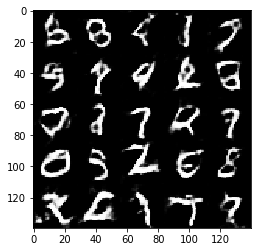

Epoch 2/2... Discriminator Loss: 1.1589... Generator Loss: 0.9707
Epoch 2/2... Discriminator Loss: 1.2713... Generator Loss: 1.8665
Epoch 2/2... Discriminator Loss: 1.0942... Generator Loss: 1.3530
Epoch 2/2... Discriminator Loss: 1.0182... Generator Loss: 1.4039
Epoch 2/2... Discriminator Loss: 1.1935... Generator Loss: 0.9963
Epoch 2/2... Discriminator Loss: 1.1344... Generator Loss: 1.1846
Epoch 2/2... Discriminator Loss: 1.1468... Generator Loss: 1.2092
Epoch 2/2... Discriminator Loss: 1.1938... Generator Loss: 1.1871
Epoch 2/2... Discriminator Loss: 1.1294... Generator Loss: 1.4114
Epoch 2/2... Discriminator Loss: 1.1581... Generator Loss: 1.4098


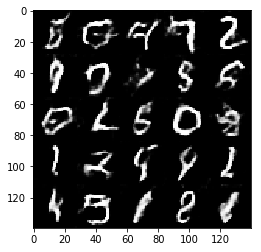

Epoch 2/2... Discriminator Loss: 0.8773... Generator Loss: 1.6819
Epoch 2/2... Discriminator Loss: 1.0603... Generator Loss: 1.4948
Epoch 2/2... Discriminator Loss: 1.0537... Generator Loss: 1.1571
Epoch 2/2... Discriminator Loss: 1.1741... Generator Loss: 1.2203
Epoch 2/2... Discriminator Loss: 1.3928... Generator Loss: 1.0160
Epoch 2/2... Discriminator Loss: 1.1769... Generator Loss: 1.1951
Epoch 2/2... Discriminator Loss: 0.9813... Generator Loss: 1.2724
Epoch 2/2... Discriminator Loss: 1.0387... Generator Loss: 1.1385
Epoch 2/2... Discriminator Loss: 1.3167... Generator Loss: 1.0551
Epoch 2/2... Discriminator Loss: 0.9439... Generator Loss: 1.7850


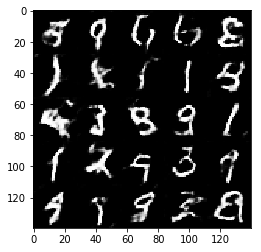

Epoch 2/2... Discriminator Loss: 1.1305... Generator Loss: 1.0923
Epoch 2/2... Discriminator Loss: 1.2125... Generator Loss: 2.0820
Epoch 2/2... Discriminator Loss: 1.2299... Generator Loss: 0.9884
Epoch 2/2... Discriminator Loss: 1.1548... Generator Loss: 1.7331
Epoch 2/2... Discriminator Loss: 1.0777... Generator Loss: 1.9825
Epoch 2/2... Discriminator Loss: 0.8792... Generator Loss: 1.1562
Epoch 2/2... Discriminator Loss: 1.1401... Generator Loss: 0.8320
Epoch 2/2... Discriminator Loss: 1.0108... Generator Loss: 1.0404
Epoch 2/2... Discriminator Loss: 1.1621... Generator Loss: 1.4284
Epoch 2/2... Discriminator Loss: 0.9238... Generator Loss: 1.2752


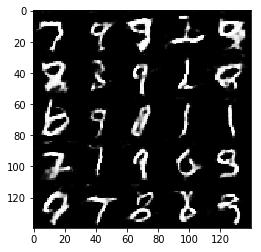

Epoch 2/2... Discriminator Loss: 1.1001... Generator Loss: 1.0888
Epoch 2/2... Discriminator Loss: 1.1319... Generator Loss: 1.5996
Epoch 2/2... Discriminator Loss: 1.1042... Generator Loss: 1.5115
Epoch 2/2... Discriminator Loss: 1.2510... Generator Loss: 1.6408
Epoch 2/2... Discriminator Loss: 1.1542... Generator Loss: 1.2532
Epoch 2/2... Discriminator Loss: 0.9935... Generator Loss: 1.1374
Epoch 2/2... Discriminator Loss: 0.8425... Generator Loss: 1.4644
Epoch 2/2... Discriminator Loss: 1.3392... Generator Loss: 1.3827
Epoch 2/2... Discriminator Loss: 1.2153... Generator Loss: 0.9616
Epoch 2/2... Discriminator Loss: 0.7955... Generator Loss: 1.6468


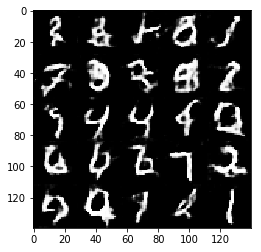

Epoch 2/2... Discriminator Loss: 1.0931... Generator Loss: 1.4021
Epoch 2/2... Discriminator Loss: 1.1595... Generator Loss: 1.0756
Epoch 2/2... Discriminator Loss: 0.9334... Generator Loss: 1.2403
Epoch 2/2... Discriminator Loss: 1.3881... Generator Loss: 1.2278
Epoch 2/2... Discriminator Loss: 1.1940... Generator Loss: 1.1941
Epoch 2/2... Discriminator Loss: 1.0154... Generator Loss: 1.3176
Epoch 2/2... Discriminator Loss: 1.2618... Generator Loss: 1.3918
Epoch 2/2... Discriminator Loss: 1.0236... Generator Loss: 1.4690
Epoch 2/2... Discriminator Loss: 1.1589... Generator Loss: 1.5132
Epoch 2/2... Discriminator Loss: 1.3358... Generator Loss: 1.5248


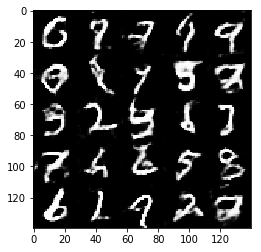

Epoch 2/2... Discriminator Loss: 1.0539... Generator Loss: 1.5457
Epoch 2/2... Discriminator Loss: 1.0012... Generator Loss: 1.0777
Epoch 2/2... Discriminator Loss: 1.2159... Generator Loss: 1.2646
Epoch 2/2... Discriminator Loss: 1.1665... Generator Loss: 1.3052
Epoch 2/2... Discriminator Loss: 1.1139... Generator Loss: 1.5426
Epoch 2/2... Discriminator Loss: 1.0177... Generator Loss: 1.0296
Epoch 2/2... Discriminator Loss: 1.0514... Generator Loss: 1.3310
Epoch 2/2... Discriminator Loss: 0.9691... Generator Loss: 1.3872
Epoch 2/2... Discriminator Loss: 1.2453... Generator Loss: 1.2971
Epoch 2/2... Discriminator Loss: 1.2811... Generator Loss: 1.0702


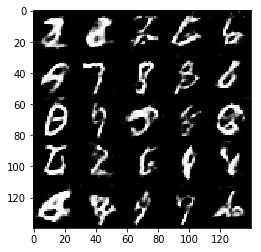

Epoch 2/2... Discriminator Loss: 1.1356... Generator Loss: 1.3336
Epoch 2/2... Discriminator Loss: 1.0521... Generator Loss: 1.3154
Epoch 2/2... Discriminator Loss: 1.1021... Generator Loss: 1.7624
Epoch 2/2... Discriminator Loss: 1.3876... Generator Loss: 0.8782
Epoch 2/2... Discriminator Loss: 1.2248... Generator Loss: 1.0001
Epoch 2/2... Discriminator Loss: 0.9620... Generator Loss: 1.4469
Epoch 2/2... Discriminator Loss: 1.1574... Generator Loss: 1.6200
Epoch 2/2... Discriminator Loss: 1.2164... Generator Loss: 1.3456
Epoch 2/2... Discriminator Loss: 1.1750... Generator Loss: 1.0564
Epoch 2/2... Discriminator Loss: 1.2197... Generator Loss: 1.0142


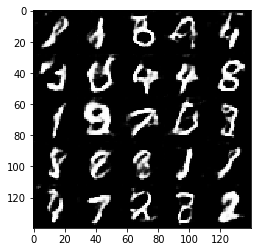

Epoch 2/2... Discriminator Loss: 0.9317... Generator Loss: 1.1478
Epoch 2/2... Discriminator Loss: 0.9678... Generator Loss: 1.5692
Epoch 2/2... Discriminator Loss: 0.9490... Generator Loss: 1.4979
Epoch 2/2... Discriminator Loss: 1.3405... Generator Loss: 1.2541
Epoch 2/2... Discriminator Loss: 0.8864... Generator Loss: 1.1793
Epoch 2/2... Discriminator Loss: 0.8244... Generator Loss: 0.9614
Epoch 2/2... Discriminator Loss: 1.0302... Generator Loss: 0.9830
Epoch 2/2... Discriminator Loss: 1.1599... Generator Loss: 1.0529
Epoch 2/2... Discriminator Loss: 1.1962... Generator Loss: 1.4807
Epoch 2/2... Discriminator Loss: 1.0720... Generator Loss: 1.2482


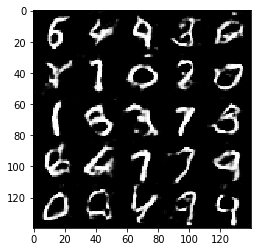

Epoch 2/2... Discriminator Loss: 0.9184... Generator Loss: 1.3903
Epoch 2/2... Discriminator Loss: 1.0810... Generator Loss: 1.1545
Epoch 2/2... Discriminator Loss: 1.0519... Generator Loss: 1.4470
Epoch 2/2... Discriminator Loss: 1.0158... Generator Loss: 1.6482
Epoch 2/2... Discriminator Loss: 1.1260... Generator Loss: 0.9960
Epoch 2/2... Discriminator Loss: 1.2077... Generator Loss: 1.5092
Epoch 2/2... Discriminator Loss: 1.2811... Generator Loss: 0.9739
Epoch 2/2... Discriminator Loss: 0.9755... Generator Loss: 1.4030
Epoch 2/2... Discriminator Loss: 1.0942... Generator Loss: 1.1883
Epoch 2/2... Discriminator Loss: 1.3647... Generator Loss: 1.1936


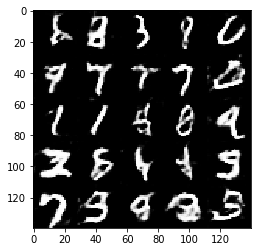

Epoch 2/2... Discriminator Loss: 1.1027... Generator Loss: 1.5926
Epoch 2/2... Discriminator Loss: 1.0662... Generator Loss: 1.5529
Epoch 2/2... Discriminator Loss: 1.0981... Generator Loss: 1.3004
Epoch 2/2... Discriminator Loss: 1.0721... Generator Loss: 1.0725
Epoch 2/2... Discriminator Loss: 1.2360... Generator Loss: 1.1348
Epoch 2/2... Discriminator Loss: 0.9778... Generator Loss: 1.8109
Epoch 2/2... Discriminator Loss: 0.9641... Generator Loss: 1.1378
Epoch 2/2... Discriminator Loss: 1.1664... Generator Loss: 1.4619
Epoch 2/2... Discriminator Loss: 0.9519... Generator Loss: 1.3803
Epoch 2/2... Discriminator Loss: 1.0976... Generator Loss: 1.1959


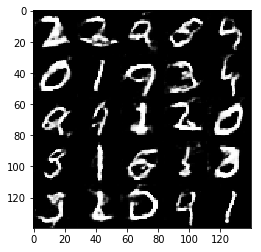

Epoch 2/2... Discriminator Loss: 0.8655... Generator Loss: 1.2566
Epoch 2/2... Discriminator Loss: 1.3133... Generator Loss: 1.0680
Epoch 2/2... Discriminator Loss: 0.9839... Generator Loss: 1.2362
Epoch 2/2... Discriminator Loss: 1.0401... Generator Loss: 1.3800
Epoch 2/2... Discriminator Loss: 1.0150... Generator Loss: 1.6404
Epoch 2/2... Discriminator Loss: 1.0994... Generator Loss: 1.2377
Epoch 2/2... Discriminator Loss: 0.9017... Generator Loss: 1.2469
Epoch 2/2... Discriminator Loss: 1.1322... Generator Loss: 1.3203
Epoch 2/2... Discriminator Loss: 0.9137... Generator Loss: 1.6295
Epoch 2/2... Discriminator Loss: 1.1412... Generator Loss: 1.8512


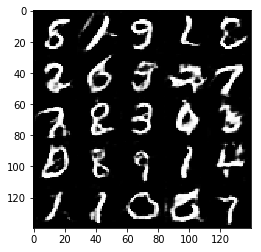

Epoch 2/2... Discriminator Loss: 0.9258... Generator Loss: 1.6186
Epoch 2/2... Discriminator Loss: 1.1723... Generator Loss: 1.2247
Epoch 2/2... Discriminator Loss: 1.0991... Generator Loss: 1.2990
Epoch 2/2... Discriminator Loss: 1.0994... Generator Loss: 1.3132
Epoch 2/2... Discriminator Loss: 1.0059... Generator Loss: 1.0534
Epoch 2/2... Discriminator Loss: 1.1754... Generator Loss: 1.9080
Epoch 2/2... Discriminator Loss: 1.0470... Generator Loss: 1.2379
Epoch 2/2... Discriminator Loss: 1.1308... Generator Loss: 1.2757
Epoch 2/2... Discriminator Loss: 0.8799... Generator Loss: 1.0137
Epoch 2/2... Discriminator Loss: 1.1605... Generator Loss: 1.2091


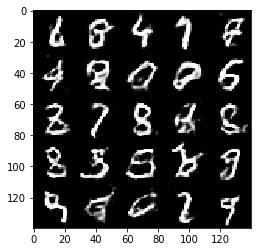

Epoch 2/2... Discriminator Loss: 1.3672... Generator Loss: 1.6110
Epoch 2/2... Discriminator Loss: 1.1217... Generator Loss: 1.8802
Epoch 2/2... Discriminator Loss: 1.0994... Generator Loss: 0.9246
Epoch 2/2... Discriminator Loss: 1.2204... Generator Loss: 1.3074
Epoch 2/2... Discriminator Loss: 1.0309... Generator Loss: 1.4494
Epoch 2/2... Discriminator Loss: 1.0807... Generator Loss: 0.9811
Epoch 2/2... Discriminator Loss: 1.1256... Generator Loss: 1.6172
Epoch 2/2... Discriminator Loss: 1.3019... Generator Loss: 1.6626
Epoch 2/2... Discriminator Loss: 0.9208... Generator Loss: 1.4836
Epoch 2/2... Discriminator Loss: 1.0507... Generator Loss: 1.7245


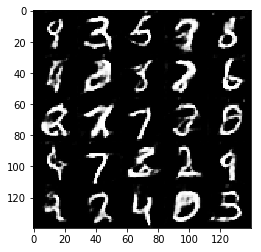

Epoch 2/2... Discriminator Loss: 0.9994... Generator Loss: 1.1234
Epoch 2/2... Discriminator Loss: 1.0775... Generator Loss: 1.8076
Epoch 2/2... Discriminator Loss: 0.9727... Generator Loss: 1.1119
Epoch 2/2... Discriminator Loss: 0.9663... Generator Loss: 1.8862
Epoch 2/2... Discriminator Loss: 1.2395... Generator Loss: 1.5404


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5275... Generator Loss: 3.8274
Epoch 1/1... Discriminator Loss: 0.6896... Generator Loss: 3.2293
Epoch 1/1... Discriminator Loss: 0.8001... Generator Loss: 2.3253
Epoch 1/1... Discriminator Loss: 0.6820... Generator Loss: 3.4104
Epoch 1/1... Discriminator Loss: 0.6263... Generator Loss: 2.6448
Epoch 1/1... Discriminator Loss: 0.7352... Generator Loss: 2.6171
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 1.8442
Epoch 1/1... Discriminator Loss: 0.5478... Generator Loss: 3.7965
Epoch 1/1... Discriminator Loss: 0.5966... Generator Loss: 2.4166
Epoch 1/1... Discriminator Loss: 0.5353... Generator Loss: 3.9616


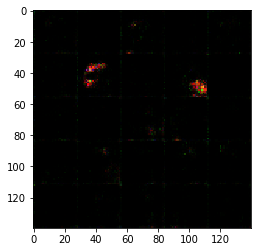

Epoch 1/1... Discriminator Loss: 0.5954... Generator Loss: 3.9004
Epoch 1/1... Discriminator Loss: 0.6456... Generator Loss: 5.7979
Epoch 1/1... Discriminator Loss: 0.5541... Generator Loss: 2.9340
Epoch 1/1... Discriminator Loss: 0.4396... Generator Loss: 4.0496
Epoch 1/1... Discriminator Loss: 0.4284... Generator Loss: 4.7646
Epoch 1/1... Discriminator Loss: 0.4543... Generator Loss: 4.4782
Epoch 1/1... Discriminator Loss: 0.4865... Generator Loss: 3.1835
Epoch 1/1... Discriminator Loss: 0.4698... Generator Loss: 4.1076
Epoch 1/1... Discriminator Loss: 0.4199... Generator Loss: 4.3809
Epoch 1/1... Discriminator Loss: 0.5065... Generator Loss: 3.5853


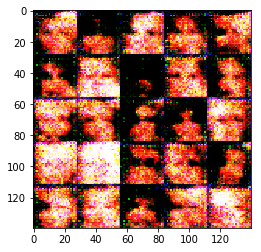

Epoch 1/1... Discriminator Loss: 0.4583... Generator Loss: 3.7791
Epoch 1/1... Discriminator Loss: 0.5000... Generator Loss: 3.8607
Epoch 1/1... Discriminator Loss: 0.5972... Generator Loss: 4.0695
Epoch 1/1... Discriminator Loss: 0.5929... Generator Loss: 2.7240
Epoch 1/1... Discriminator Loss: 0.5344... Generator Loss: 3.7861
Epoch 1/1... Discriminator Loss: 0.5516... Generator Loss: 3.2052
Epoch 1/1... Discriminator Loss: 0.4948... Generator Loss: 3.6719
Epoch 1/1... Discriminator Loss: 0.4921... Generator Loss: 3.4948
Epoch 1/1... Discriminator Loss: 0.5967... Generator Loss: 2.9208
Epoch 1/1... Discriminator Loss: 0.6209... Generator Loss: 2.8027


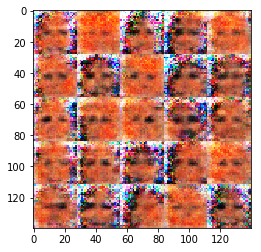

Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 2.1363
Epoch 1/1... Discriminator Loss: 0.5400... Generator Loss: 4.7040
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 1.9230
Epoch 1/1... Discriminator Loss: 0.4334... Generator Loss: 3.4253
Epoch 1/1... Discriminator Loss: 0.6998... Generator Loss: 2.1595
Epoch 1/1... Discriminator Loss: 0.6725... Generator Loss: 2.2644
Epoch 1/1... Discriminator Loss: 0.9248... Generator Loss: 2.3225
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 1.9458
Epoch 1/1... Discriminator Loss: 0.6395... Generator Loss: 2.6487
Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 1.6702


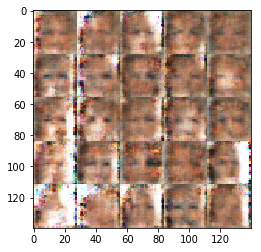

Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 1.9721
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 1.7882
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 1.3846
Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 1.3261
Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 1.6502
Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 1.7315
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 1.8291... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 1.8293
Epoch 1/1... Discriminator Loss: 1.6372... Generator Loss: 1.1039


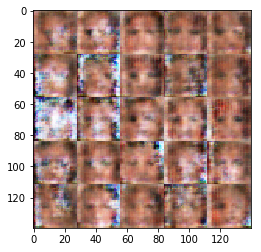

Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 1.1508
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 1.5511
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 1.6716
Epoch 1/1... Discriminator Loss: 1.0351... Generator Loss: 1.2404
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 2.1381
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 1.3076
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 2.1270
Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 1.6036
Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 1.5424


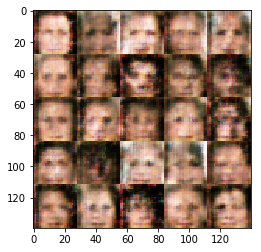

Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 2.0471
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 1.2329
Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 1.6539
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 1.2158
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 1.0792
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 1.8477
Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 1.2411
Epoch 1/1... Discriminator Loss: 0.9093... Generator Loss: 1.5098
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 1.4902
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 1.3878


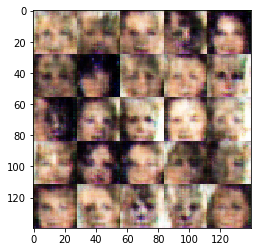

Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 1.3535
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 1.2351
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 1.6222
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 1.2781
Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 1.8574
Epoch 1/1... Discriminator Loss: 0.9178... Generator Loss: 1.9688
Epoch 1/1... Discriminator Loss: 0.9140... Generator Loss: 1.6197
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 1.1984
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 1.4603
Epoch 1/1... Discriminator Loss: 0.9090... Generator Loss: 1.6192


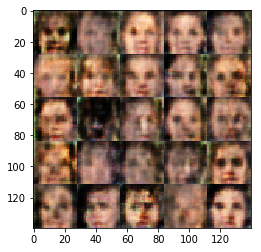

Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 1.2873
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.9837
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 1.0389
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 1.3991
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 1.4884
Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 1.4553
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 1.1919
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 1.0535
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 1.1323


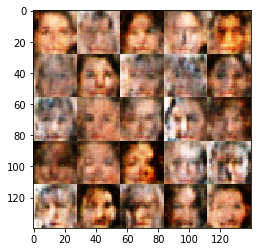

Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 1.6568
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 1.8079
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 1.3202
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 1.7039
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 1.3250
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 1.5714
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 1.3607
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 1.0928
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 1.2240
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 1.8786


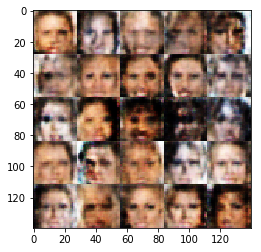

Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 1.1963
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 1.1979
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 1.0709
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 1.1460
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.9728
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 1.3297
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 1.1927
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.9249
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 1.2280


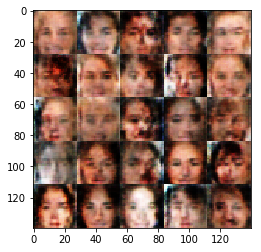

Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 1.2428
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 1.5431
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 1.2686
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 1.1022
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 1.1853
Epoch 1/1... Discriminator Loss: 1.0290... Generator Loss: 1.2761
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 1.1787
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 1.1993
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 1.3230


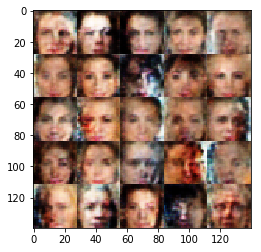

Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 1.2076
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 1.1841
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 1.4106
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 1.1363
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.9310
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 1.0790
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 1.1016
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.9478
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 1.0744
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 1.3530


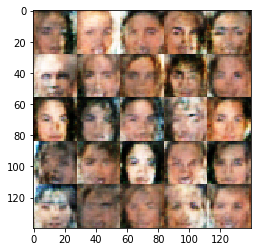

Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 1.0868
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 1.1216
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 1.0942
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 1.0157
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 0.9820
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 1.2124
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.9633
Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 1.1393
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 1.2338


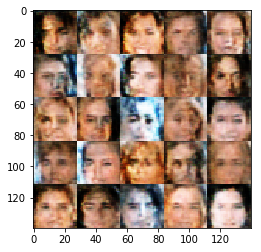

Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 1.2451
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 1.2408
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 1.1893
Epoch 1/1... Discriminator Loss: 1.1289... Generator Loss: 1.3254
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 1.2355
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 1.0856
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 1.1942
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 1.1278


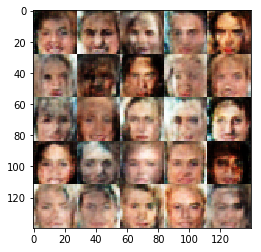

Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 1.2044
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 1.0383
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.9890
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 1.3157
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 1.0546
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 1.1178
Epoch 1/1... Discriminator Loss: 1.6528... Generator Loss: 0.9480
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 1.2786
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 1.1030


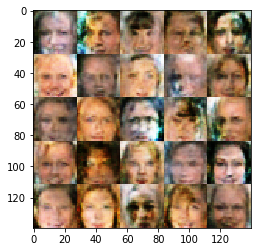

Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.9147
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.9580
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 1.0295
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 1.0745
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 1.2570
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.9883
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 1.0770
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 1.2151
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 1.1750


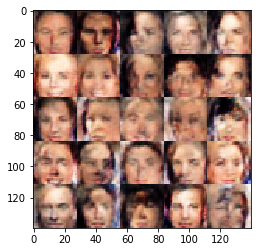

Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 1.1621
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 1.0367
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 1.2145
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 1.0861
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 1.0984
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.9572
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 1.0009
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 1.1134
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 1.2320
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 1.0370


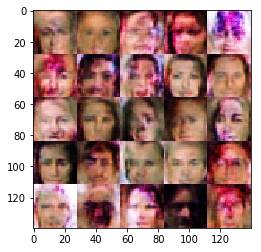

Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 1.1121
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 1.1534
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 1.0025
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 1.0456
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 1.0486
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.9153
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 1.0349
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.9806


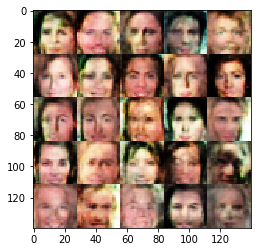

Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 1.0829
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 1.2434
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 1.0834
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 1.1163
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 1.0253
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 1.0033
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.9912


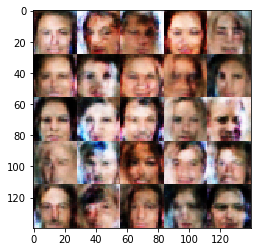

Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.9159
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 1.0571
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 1.2499
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 1.2313
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 1.1502


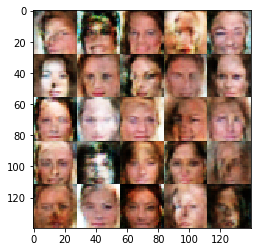

Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 1.0980
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 1.0406
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 1.1733
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 1.3221
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 1.0793
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 1.2372


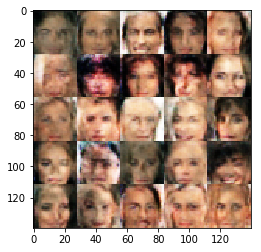

Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 1.0032
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 1.0478
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 1.0712
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 1.2021
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 1.0744
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.9269
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 1.0609
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.9805


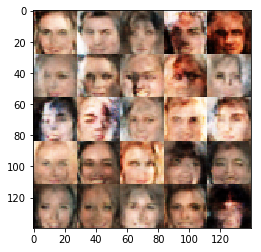

Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 0.9423
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.9837
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 1.2372
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 1.2122
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.9686
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 1.1188
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 1.0109


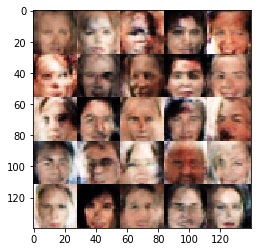

Epoch 1/1... Discriminator Loss: 1.2011... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 1.0647
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 1.0471
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 1.0146
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 1.0994
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 1.0468
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 1.0522


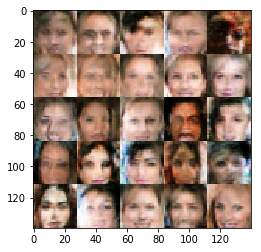

Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.9478
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.9408
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 1.1520
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.9206
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.9458
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.8129


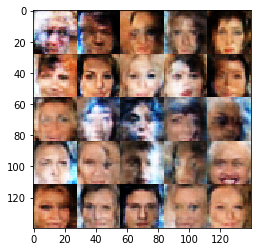

Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.9653
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 1.1854
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 1.1641
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 1.3235
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 1.0463
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 1.0514
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 1.0459


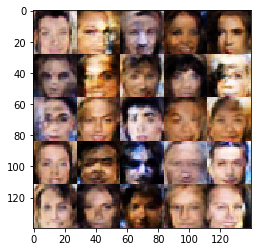

Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.9359
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 1.0687
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 1.0285
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 1.1196
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 1.1014
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 1.1672
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 1.0621


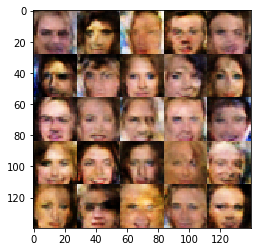

Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 1.1887
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 1.0367
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.9804
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.9840
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 1.1381
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 1.0982
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.9860


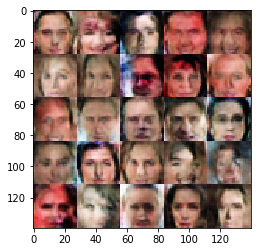

Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 1.0862
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 1.0710
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 1.0634
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 1.0165
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 1.1046
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 1.0735
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.8347


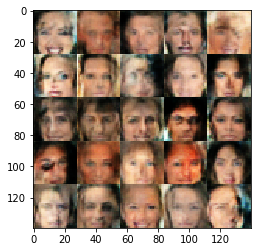

Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 1.0484
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.9690
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 1.1248
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 1.1331
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 1.0055
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 1.2362


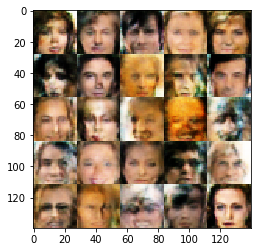

Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 0.9835
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 1.0463
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 1.2217
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 1.0089
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 1.0663
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.9584


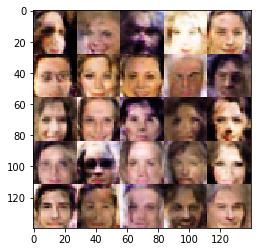

Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.9726
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 1.2241
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 1.1130
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 1.0928
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.8601


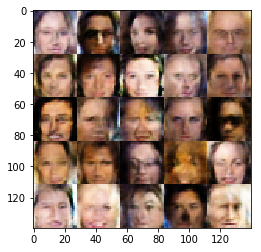

Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 1.0641
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 1.0702
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 1.0793


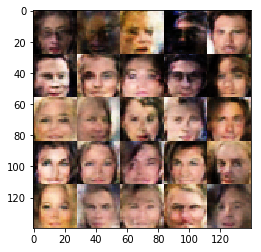

Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 0.9986
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.9332
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.9863
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 1.0345
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.9161
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.8277


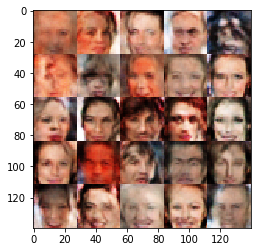

Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.9844
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 1.2066
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 1.0809
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 1.0105
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.9917
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 1.0440
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.9609
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.7322


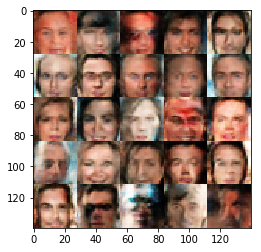

Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.9786
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 1.1806
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 1.1715
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.9852
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.9417


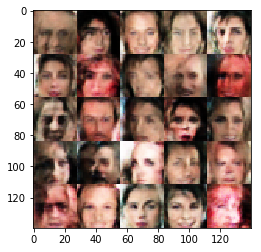

Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.8898
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 1.0192
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 1.0456
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.9974
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 1.0319
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 1.0704
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 1.0799


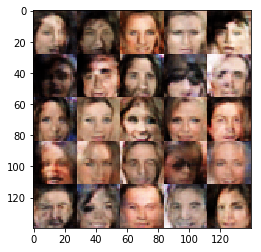

Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 1.0625
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.9925
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 1.1264
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 0.9845
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 1.0528
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 1.0387


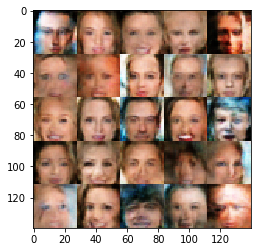

Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 1.1416
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 1.0625
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 1.0411
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.9986
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 1.1505
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.9860


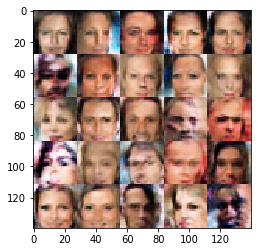

Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.9609
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.9345
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 1.0838
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.9625
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 1.0767
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.9954
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.8762
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.9906


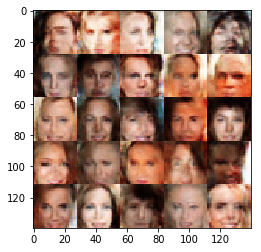

Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.9951
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.9161
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.9306
Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 1.0939
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 1.0003


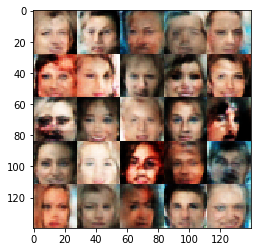

Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 1.0543
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 1.1431
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.9485
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 1.1516
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 1.0704
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.9019
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 1.0006


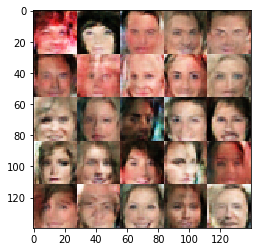

Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.9269
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 1.2439
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 1.0075
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.9377
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 1.2259


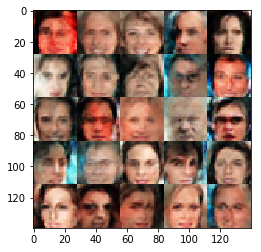

Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 1.1268
Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.9382
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 1.0602
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 1.1468
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 1.0393
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.9065
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 1.0863


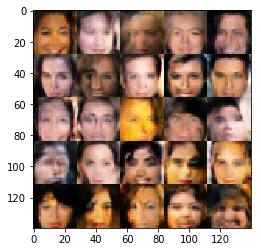

Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 1.2018
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 0.9494
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 1.0616
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 1.1113
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 1.0388
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.8858


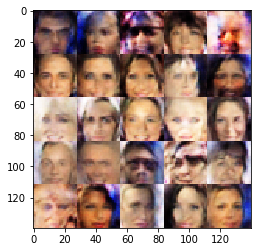

Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 1.0055
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.9081
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 0.9378
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 1.0167
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 1.0595
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.8610


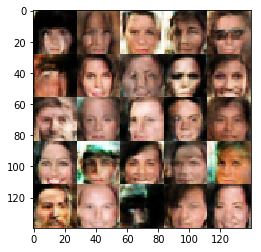

Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 1.0490
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 1.0167
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 1.0597
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 1.0221


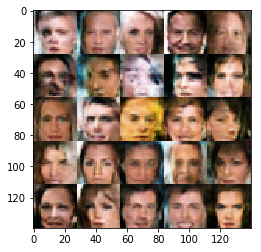

Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 1.0237
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 1.0567
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 1.1942
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 1.1223
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.9403
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 1.0525
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.9182


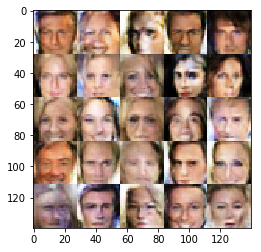

Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.9625
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 1.1449
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 1.0368
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 1.1625
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 1.0375
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 1.2842


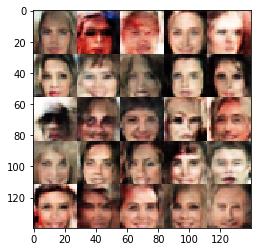

Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.9771
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 1.1125
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 1.0612
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.9064
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.9551
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 1.0840
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 1.0400


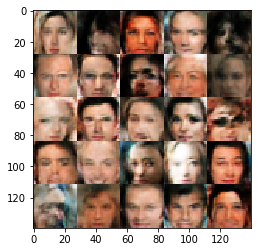

Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.9604
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 1.0641
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.8823
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.8944
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.9553
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 1.0632
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 1.1283
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 1.1298
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 1.1261


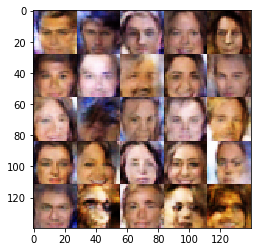

Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.9653
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.9928
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 1.0389
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 1.1060
Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 1.1049
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 1.1262


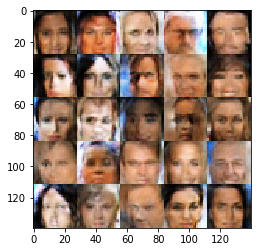

Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 1.0348
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 1.0192
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 1.2749
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.8672


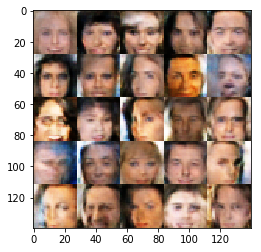

Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 1.0193
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 1.1371
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 1.1665
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 1.0851
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 1.1281
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 1.0398
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 1.0339
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.8454


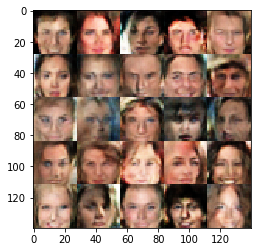

Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 1.1759
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 1.0133
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.9648
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.9679
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 1.0391
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 1.1334
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 1.1048
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.9894


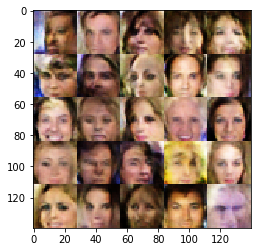

Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.9226
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 1.0680
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 1.0413
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 1.2913
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 1.0605
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 1.2392
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 1.1179
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.9196


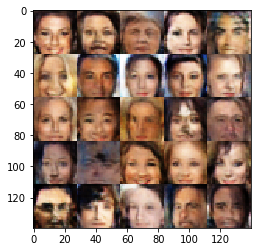

Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 1.0353
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 1.0739
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.9587
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 1.3908
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.8798
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 1.0171
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.8422


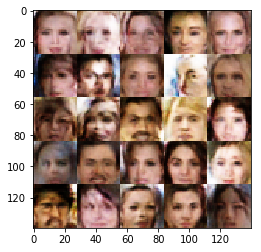

Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 1.0782
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 0.9461
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.9619
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.9209
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.8874


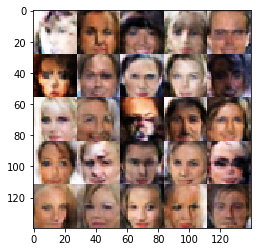

Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 1.0907
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 1.0154
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 1.1000
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 1.0299
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 1.1045
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.9322
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.9920
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.9696


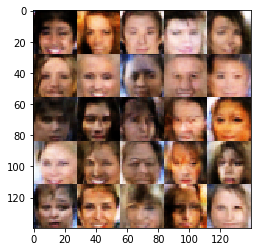

Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.9649
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 1.1255
Epoch 1/1... Discriminator Loss: 1.0972... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 1.0822
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 1.3265
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 1.1444
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.9289


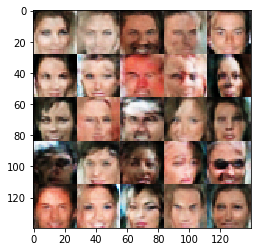

Epoch 1/1... Discriminator Loss: 1.5091... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.9960
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 1.2048
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 1.1934
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.8940
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.9697


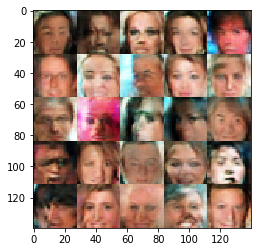

Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 1.0663
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 1.0784
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 1.1938
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 1.2399
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 1.1022


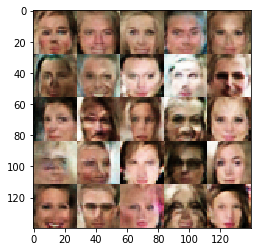

Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 1.0107
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 0.9102


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.